In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore") #"default"

# **TimeSeries**

In [ ]:
ts = pd.read_csv('/content/TotalSales.csv')
ts

,SalesDate,TotalSales
0,2011-05-31 00:00:00.000,567020.9498
1,2011-06-01 00:00:00.000,15394.3298
2,2011-06-02 00:00:00.000,16588.4572
3,2011-06-03 00:00:00.000,7907.9768
4,2011-06-04 00:00:00.000,16588.4572
...,...,...
1119,2014-06-26 00:00:00.000,1660.6501
1120,2014-06-27 00:00:00.000,1931.1761
1121,2014-06-28 00:00:00.000,2041.4440
1122,2014-06-29 00:00:00.000,1632.7596


In [ ]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SalesDate   1124 non-null   object 
 1   TotalSales  1124 non-null   float64
dtypes: float64(1), object(1)
memory usage: 17.7+ KB


In [ ]:
ts.describe()

,TotalSales
count,1.124000e+03
mean,1.096235e+05
std,4.844997e+05
min,7.725036e+02
25%,1.559133e+04
50%,2.382283e+04
75%,4.171030e+04
max,4.800611e+06


In [ ]:
ts['SalesDate'] = pd.to_datetime(ts['SalesDate'])
ts['Month'] = ts['SalesDate'].dt.month
ts['Year'] = ts['SalesDate'].dt.year
count_days = ts.groupby(['Year', 'Month'])['SalesDate'].count()
count_days[count_days < 28]

Year  Month
2011  5        1
Name: SalesDate, dtype: int64

In [ ]:
print(ts.loc[(ts['Year'] == 2011) & (ts['Month'] == 5)])

   SalesDate   TotalSales  Month  Year
0 2011-05-31  567020.9498      5  2011


In [ ]:
ts.drop(ts[(ts['Year'] == 2011) & (ts['Month'] == 5)].index, inplace=True)

In [ ]:
MonthlySales = ts.groupby(['Year', 'Month'])['TotalSales'].sum()

In [ ]:
MS = MonthlySales.to_frame().reset_index()
MS['MonthYear'] = MS['Month'].astype(str) + '-' + MS['Year'].astype(str)
MS.drop(['Year','Month'], axis=1, inplace=True)
MS

In [ ]:
MS.describe()

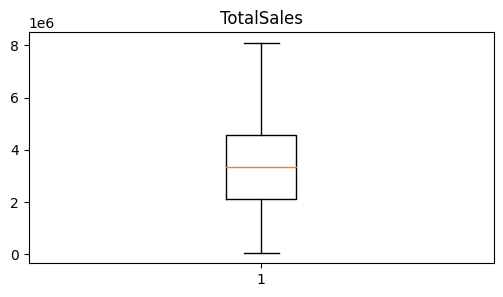

In [ ]:
# Kiểm tra outlier
fig, ax = plt.subplots(figsize=(6, 3))

ax.boxplot(MS["TotalSales"])
ax.set_title("TotalSales")

plt.show()

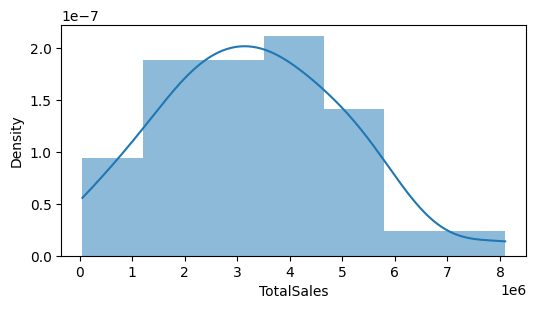

In [ ]:
# Kiểm tra phân bổ
fig, ax = plt.subplots(1, 1, figsize=(6,3))

sns.histplot(MS['TotalSales'], kde=True, stat="density", linewidth=0)

plt.show()

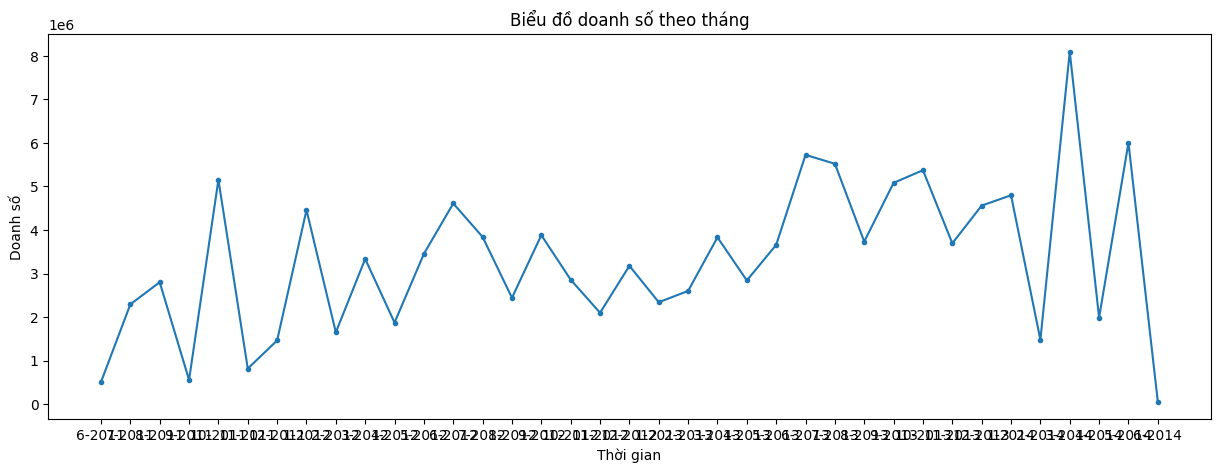

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(MS['MonthYear'], MS['TotalSales'], marker = '.')

plt.title('Biểu đồ doanh số theo tháng')
plt.xlabel('Thời gian')
plt.ylabel('Doanh số')
plt.show()

In [ ]:
# Chuyển đổi cột MonthYear thành kiểu datetime
MS['MonthYear'] = pd.to_datetime(MS['MonthYear'], format='%m-%Y')

In [ ]:
# Chia tập train và test
train_MS = MS[MS['MonthYear'] < '04-2014']
test_MS = MS[MS['MonthYear'] >= '04-2014']

In [ ]:
print("Train:", len(train_MS))
print("Test:", len(test_MS))

Train: 34
Test: 3


In [ ]:
p = int(input("Nhập giá trị p: "))
d = int(input("Nhập giá trị d: "))
q = int(input("Nhập giá trị q: "))
f = int(input("Nhập giá trị f: "))

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

models = [
    {
        'name': 'ARIMA',
        'model': ARIMA,
        'params': {'order': (p, d, q)}
    },
    {
        'name': 'Exponential Smoothing',
        'model': ExponentialSmoothing,
        'params': {'seasonal': 'add', 'seasonal_periods': f}
    }
]

for model_info in models:
    model_name = model_info['name']
    model_class = model_info['model']
    model_params = model_info['params']

    model = model_class(train_MS['TotalSales'], **model_params)
    fit_model = model.fit()
    forecast = fit_model.predict(start=test_MS.index[0], end=test_MS.index[-1])

    mae = mean_absolute_error(test_MS['TotalSales'], forecast)
    rmse = np.sqrt(mean_squared_error(test_MS['TotalSales'], forecast))

    print(f"{model_name} MAE: {mae}")
    print(f"{model_name} RMSE: {rmse}")

Nhập giá trị p: 2
Nhập giá trị d: 0
Nhập giá trị q: 0
Nhập giá trị f: 12
ARIMA MAE: 1447586.6543234894
ARIMA RMSE: 1794523.3497202306
Exponential Smoothing MAE: 2798210.424686199
Exponential Smoothing RMSE: 3559803.3102481347


**So sánh trực quan theo ARIMA**

In [ ]:
train_ms = train_MS.set_index('MonthYear')
test_ms = test_MS.set_index('MonthYear')

In [ ]:
ARM = ARIMA(train_ms['TotalSales'], order = (p,d,q))

In [ ]:
fit_ARM = ARM.fit()

In [ ]:
n = len(test_MS)
lst1 = []
for i in range(0,n,1):
  forecast_train = fit_ARM.forecast(steps=n)[i]
  lst1.append(forecast_train)
#lst
forecast_sales = pd.Series(lst1)
forecast_sales

0    2.494471e+06
1    5.101971e+06
2    2.984115e+06
dtype: float64

In [ ]:
forcast_next_months = pd.date_range(start=train_ms.index[-1], periods=n, freq='M')[:len(test_MS)]
forcast_next_months

DatetimeIndex(['2014-03-31', '2014-04-30', '2014-05-31'], dtype='datetime64[ns]', freq='M')

In [ ]:
forecast_sales = pd.Series(lst1, index=forcast_next_months)

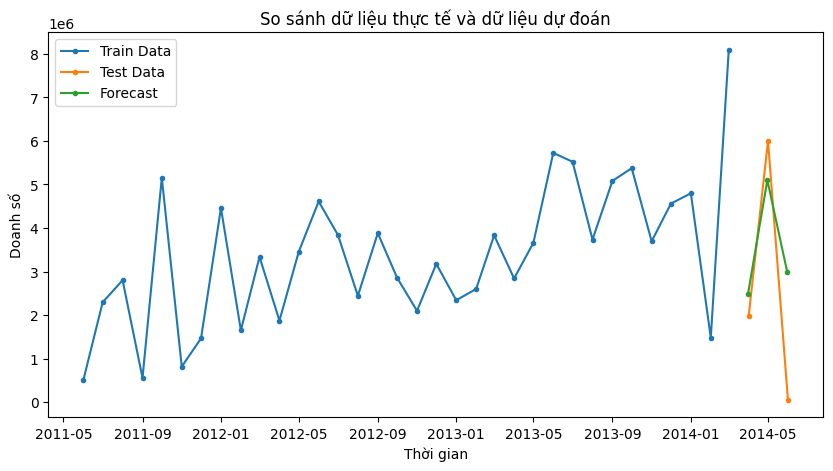

In [ ]:
plt.figure(figsize=(10, 5))

# Biểu đồ dữ liệu thực tế
plt.plot(train_ms.index, train_ms['TotalSales'], label='Train Data', marker='.')
plt.plot(test_ms.index, test_ms['TotalSales'], label='Test Data', marker='.')

# Biểu đồ dữ liệu dự đoán
plt.plot(forecast_sales.index, forecast_sales, label='Forecast', marker='.')

plt.title('So sánh dữ liệu thực tế và dữ liệu dự đoán')
plt.xlabel('Thời gian')
plt.ylabel('Doanh số')
plt.legend()
plt.show()


**Dự đoán các tháng tiếp theo theo ARIMA**

In [ ]:
ms = MS.set_index('MonthYear')

In [ ]:
arm = ARIMA(ms['TotalSales'], order = (p,d,q))

In [ ]:
fit_arm = arm.fit()

In [ ]:
# Dự đoán các tháng tiếp theo
n = int(input("Số tháng tiếp theo: "))
lst = []
for i in range(0,n,1):
  forecast = fit_arm.forecast(steps=n)[i]
  lst.append(forecast)
#lst
forecast_Sales = pd.Series(lst)
forecast_Sales

Số tháng tiếp theo: 5


0    4.941769e+06
1    1.661199e+06
2    4.254962e+06
3    2.460495e+06
4    3.844268e+06
dtype: float64

In [ ]:
#tao ra cac ngay du doan
future_next_months = pd.date_range(start=ms.index[-1], periods=n, freq='M')[0:]
future_next_months

DatetimeIndex(['2014-06-30', '2014-07-31', '2014-08-31', '2014-09-30',
               '2014-10-31'],
              dtype='datetime64[ns]', freq='M')

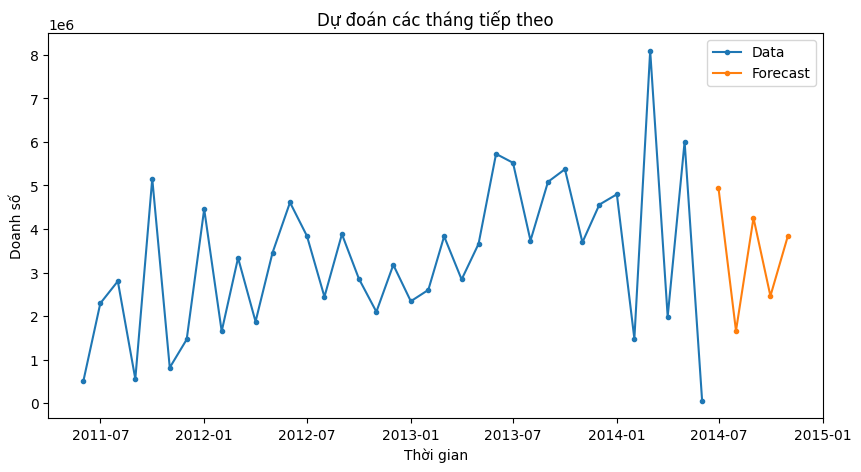

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(ms.index, ms['TotalSales'], label='Data',  marker = '.')
plt.plot(future_next_months, forecast_Sales, label='Forecast', marker = '.')

plt.title('Dự đoán các tháng tiếp theo')
plt.xlabel('Thời gian')
plt.ylabel('Doanh số')
plt.legend()
plt.show()

In [ ]:
forecast_df = pd.DataFrame({
    'future_next_months': future_next_months,
    'forecast_Sales': forecast_Sales
})

forecast_df['future_next_months'] = forecast_df['future_next_months'].dt.strftime('%m-%Y')

forecast_df

,future_next_months,forecast_Sales
0,07-2014,4.941769e+06
1,08-2014,1.661199e+06
2,09-2014,4.254962e+06
3,10-2014,2.460495e+06
4,11-2014,3.844268e+06


In [ ]:
from google.colab import files
forecast_df.to_csv('Forcast.csv')
files.download('Forcast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Phân cụm khách hàng**

In [ ]:
rfm = pd.read_csv('/content/RFM.csv')
rfm

In [ ]:
RFM = rfm[['recency','frequency','monetary']]
RFM

,recency,frequency,monetary
0,1044,2,4842.9388
1,911,1,3953.9884
2,850,2,4589.3413
3,309,1,606.6229
4,43,2,142.5119
...,...,...,...
19091,365,4,111168.3274
19092,1034,9,148385.9496
19093,426,1,1459.2824
19094,699,8,307946.0796


In [ ]:
RFM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19096 entries, 0 to 19095
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    19096 non-null  int64  
 1   frequency  19096 non-null  int64  
 2   monetary   19096 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 447.7 KB


In [ ]:
RFM.describe()

,recency,frequency,monetary
count,19096.000000,19096.000000,19096.000000
mean,359.254504,1.646523,6452.407826
std,285.220786,1.457759,43782.060657
min,1.000000,1.000000,1.518300
25%,145.000000,1.000000,60.752900
50%,279.000000,1.000000,606.622900
75%,502.000000,2.000000,3124.637375
max,1126.000000,28.000000,989184.082000


In [ ]:
RFM.isnull().sum()

recency      0
frequency    0
monetary     0
dtype: int64

In [ ]:
RFM.duplicated().sum()

1423

In [ ]:
RFM[RFM.duplicated()]

,recency,frequency,monetary
196,371,1,596.6890
407,113,1,5.5140
711,303,1,77.3169
907,362,1,44.1779
1003,953,1,3953.9884
...,...,...,...
18989,298,1,44.1779
18996,902,1,3953.9884
19000,187,1,43.0729
19006,180,1,76.2119


<Axes: >

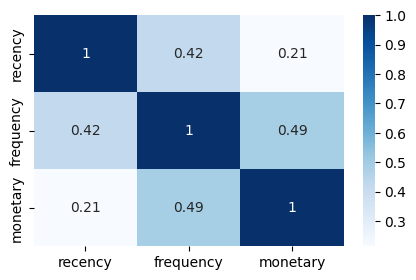

In [ ]:
plt.figure(figsize = (5,3))
sns.heatmap(data = RFM.corr(), cmap = 'Blues', annot = True)

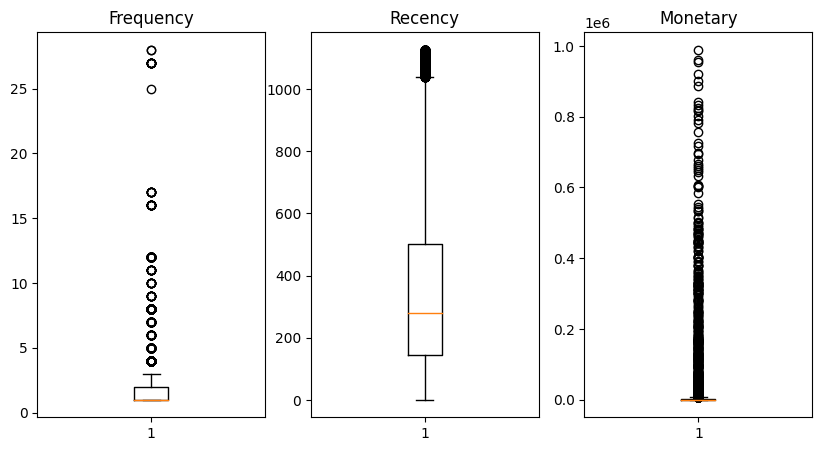

In [ ]:
# Kiểm tra outlier
fig, axs = plt.subplots(1,3, figsize=(10, 5))

axs[0].boxplot(RFM["frequency"])
axs[0].set_title("Frequency")

axs[1].boxplot(RFM["recency"])
axs[1].set_title("Recency")

axs[2].boxplot(RFM["monetary"])
axs[2].set_title("Monetary")

plt.show()

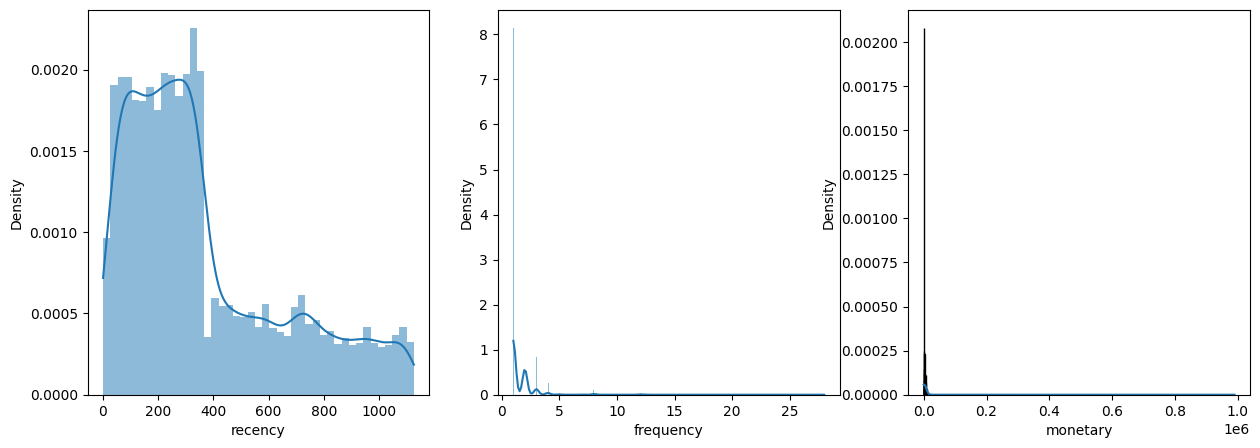

In [ ]:
# Kiểm tra phân bổ
fig, ax = plt.subplots(1, 3, figsize=(15,5))

sns.histplot(RFM['recency'], ax = ax[0], kde=True, stat="density", linewidth=0)
sns.histplot(RFM['frequency'], ax = ax[1], kde=True, stat="density", linewidth=0)
sns.histplot(RFM['monetary'], ax = ax[2], kde=True, stat="density", linewidth=1)

plt.show()

In [ ]:
import plotly.express as px
import numpy as np

fig = px.scatter_3d(rfm, x = RFM["recency"], y = RFM["frequency"], z = RFM["monetary"], title = 'RFM theo KH',  width = 800, height = 600)
fig.show()

In [ ]:
# Transform
from scipy import stats
def analyze_skewness_all(x, y, z):
    fig, ax = plt.subplots(3, 4, figsize = (15,7))

    sns.histplot(RFM[x], ax = ax[0,0], kde = True, stat = "density", linewidth = 0)
    sns.histplot(np.log(RFM[x]), ax = ax[0,1], kde = True, stat = "density", linewidth = 0)
    sns.histplot(np.sqrt(RFM[x]), ax = ax[0,2], kde = True, stat = "density", linewidth = 0)
    sns.histplot(stats.boxcox(RFM[x])[0], ax = ax[0,3], kde = True, stat = "density", linewidth = 0)

    sns.histplot(RFM[y], ax = ax[1,0], kde = True, stat = "density", linewidth = 0)
    sns.histplot(np.log(RFM[y]), ax = ax[1,1], kde = True, stat = "density", linewidth = 0)
    sns.histplot(np.sqrt(RFM[y]), ax = ax[1,2], kde = True, stat = "density", linewidth = 0)
    sns.histplot(stats.boxcox(RFM[y])[0], ax = ax[1,3], kde = True, stat = "density", linewidth = 0)

    sns.histplot(RFM[z], ax = ax[2,0], kde = True, stat = "density", linewidth = 0)
    sns.histplot(np.log(RFM[z]), ax = ax[2,1], kde = True, stat = "density", linewidth = 0)
    sns.histplot(np.sqrt(RFM[z]), ax = ax[2,2], kde = True, stat = "density", linewidth = 0)
    sns.histplot(stats.boxcox(RFM[z])[0], ax = ax[2,3], kde = True, stat = "density", linewidth = 0)

    plt.tight_layout()
    plt.show()

    print(x, 'Skewness :Original:', RFM[x].skew().round(2), 'Log:', np.log(RFM[x]).skew().round(2), 'Sqrt:',np.sqrt(RFM[x]).skew().round(2), 'Boxcox:', pd.Series(stats.boxcox(RFM[x])[0]).skew().round(2))
    print(y, 'Skewness :Original:', RFM[y].skew().round(2), 'Log:', np.log(RFM[y]).skew().round(2), 'Sqrt:',np.sqrt(RFM[y]).skew().round(2), 'Boxcox:', pd.Series(stats.boxcox(RFM[y])[0]).skew().round(2))
    print(z, 'Skewness :Original:', RFM[z].skew().round(2), 'Log:', np.log(RFM[z]).skew().round(2), 'Sqrt:',np.sqrt(RFM[z]).skew().round(2), 'Boxcox:', pd.Series(stats.boxcox(RFM[z])[0]).skew().round(2))

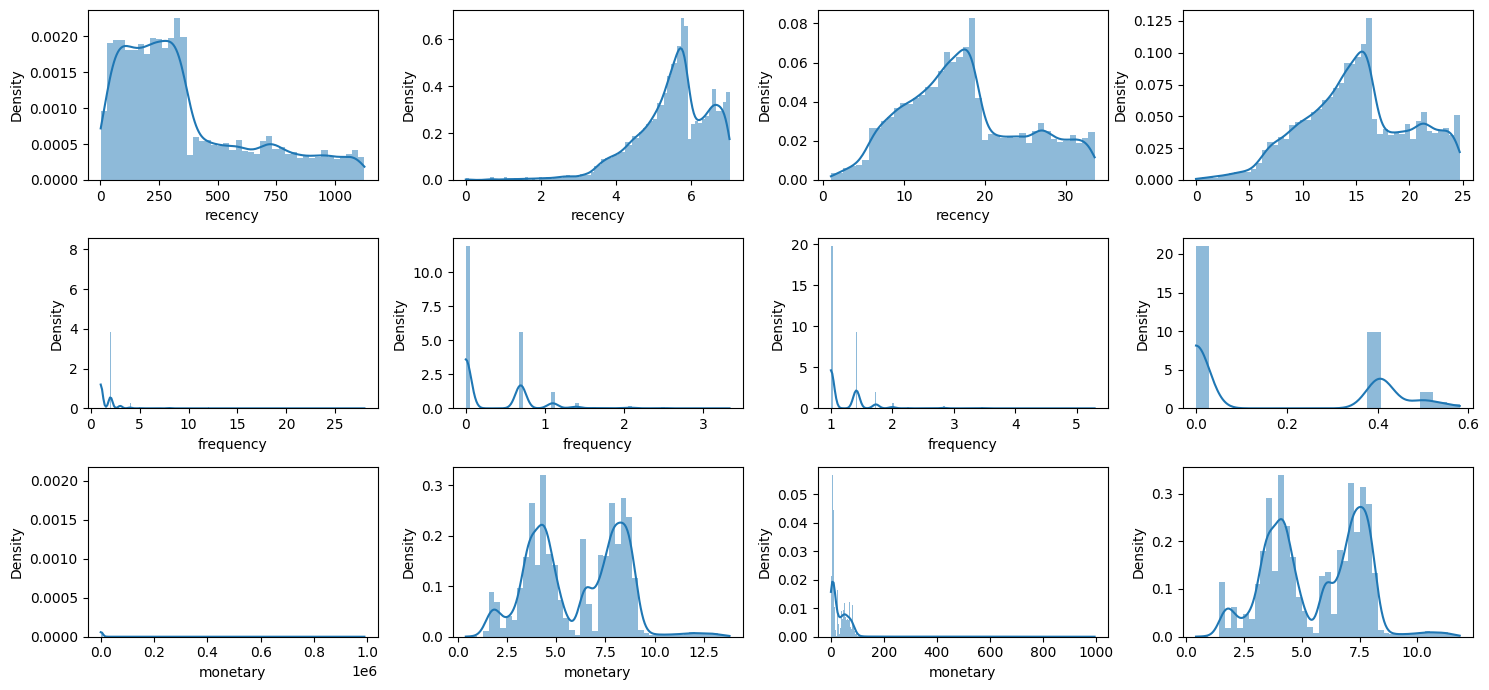

recency Skewness :Original: 1.04 Log: -1.0 Sqrt: 0.35 Boxcox: -0.04
frequency Skewness :Original: 7.39 Log: 1.56 Sqrt: 3.28 Boxcox: 0.52
monetary Skewness :Original: 12.79 Log: 0.11 Sqrt: 6.94 Boxcox: 0.01


In [ ]:
analyze_skewness_all('recency','frequency','monetary')

In [ ]:
# Tạo df sau transform
RFM_trans = pd.DataFrame()
RFM_trans['recency'] = stats.boxcox(RFM['recency'])[0]
RFM_trans['frequency'] = stats.boxcox(RFM['frequency'])[0]
RFM_trans['monetary'] = stats.boxcox(RFM['monetary'])[0]
RFM_trans.head()

,recency,frequency,monetary
0,24.089510,0.405367,7.713198
1,22.973825,0.000000,7.545764
2,22.423968,0.405367,7.668867
3,15.590982,0.000000,5.960768
4,7.054247,0.405367,4.688679


In [ ]:
fig = px.scatter_3d(rfm, x = RFM_trans["recency"], y = RFM_trans["frequency"], z = RFM_trans["monetary"], title='RFM theo KH',  width = 800, height = 600)
fig.show()

In [ ]:
# Normalizing thong qua do lech chuan
from sklearn.preprocessing import StandardScaler

Clus_rfm = StandardScaler().fit_transform(RFM_trans)
Clus_rfm

array([[ 1.81058733,  1.09680871,  1.05249023],
       [ 1.58670066, -0.79272514,  0.97000042],
       [ 1.47635982,  1.09680871,  1.03064976],
       ...,
       [ 0.49531337, -0.79272514,  0.55894475],
       [ 1.17728201,  1.84704312,  2.66012131],
       [ 0.40319463,  1.67196871,  2.52116386]])

In [ ]:
df_rfm = pd.DataFrame(Clus_rfm, columns = ['recency', 'frequency', 'monetary'])
df_rfm.head()

,recency,frequency,monetary
0,1.810587,1.096809,1.052490
1,1.586701,-0.792725,0.970000
2,1.476360,1.096809,1.030650
3,0.105171,-0.792725,0.189121
4,-1.607912,1.096809,-0.437599


**Chọn K bằng Elbow**

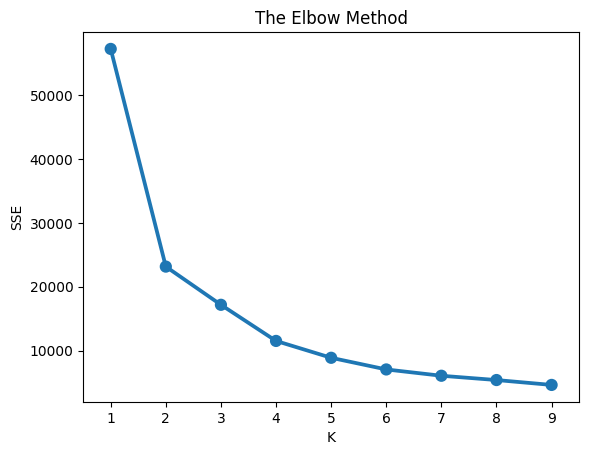

In [ ]:
from sklearn.cluster import KMeans

sse = {}
for K in range(1, 10):
    kmeans = KMeans(n_clusters = K, random_state = 42)
    kmeans.fit(Clus_rfm)
    sse[K] = kmeans.inertia_

plt.title('The Elbow Method')
plt.xlabel('K')
plt.ylabel('SSE')
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show()

**Chọn K = 4**

In [ ]:
#clustering theo thuat toan lloyd voi K = 4
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12, random_state = 42)
k_means.fit(Clus_rfm)
label_K4 = k_means.labels_
print(label_K4)

[0 0 0 ... 3 0 0]


In [ ]:
#Them cot K4 vao df de ve do thi
df_rfm['K4'] = label_K4
df_rfm.head()

,recency,frequency,monetary,K4
0,1.810587,1.096809,1.052490,0
1,1.586701,-0.792725,0.970000,0
2,1.476360,1.096809,1.030650,0
3,0.105171,-0.792725,0.189121,3
4,-1.607912,1.096809,-0.437599,2


In [ ]:
unique_K4 = set(label_K4)
unique_K4

{0, 1, 2, 3}

In [ ]:
fig = px.scatter_3d(df_rfm, x = df_rfm["recency"], y = df_rfm["frequency"], z = df_rfm["monetary"], color = "K4", title = 'RFM theo KH',  width = 800, height = 600)
fig.show()

In [ ]:
# thêm các cột từ data ban đầu OrderCount	avg_quantity	avg_unit_price	TotalSales
df_rfm["CustomerID"] = rfm["CustomerID"]
df_rfm["recency"] = RFM["recency"]
df_rfm["frequency"] = RFM["frequency"]
df_rfm["monetary"] = RFM["monetary"]
df_rfm

,recency,frequency,monetary,K4,CustomerID
0,1044,2,4842.9388,0,17241
1,911,1,3953.9884,0,28648
2,850,2,4589.3413,0,20158
3,309,1,606.6229,3,25731
4,43,2,142.5119,2,11668
...,...,...,...,...,...
19091,365,4,111168.3274,0,30093
19092,1034,9,148385.9496,0,30096
19093,426,1,1459.2824,3,30099
19094,699,8,307946.0796,0,30113


In [ ]:
from google.colab import files
df_rfm.to_csv('RFM_K4.csv')
files.download('RFM_K4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Bảng phụ**

In [ ]:
Profit = pd.read_csv('/content/Profit.csv')
Profit

,CustomerID,CustomerName,avg_quantity,avg_unit_price,TotalRevenue,TotalCost,TotalProfit
0,11000,Jon Yang,1,1031.1237,8248.9900,4735.2995,3513.6905
1,11001,Eugene Huang,1,580.3527,6383.8800,3587.9961,2795.8839
2,11002,Ruben Torres,1,2028.5100,8114.0400,4659.1599,3454.8801
3,11003,Christy Zhu,1,904.3655,8139.2900,4672.1636,3467.1264
4,11004,Elizabeth Johnson,1,1366.0016,8196.0100,4694.1049,3501.9051
...,...,...,...,...,...,...,...
19114,30114,Kevin Verboort,1,223.7346,11652.9911,10541.2722,1111.7189
19115,30115,Dora Verdad,2,382.1191,8917.5594,9234.7959,-317.2365
19116,30116,Wanda Vernon,2,603.3624,190906.1670,204356.7010,-13450.5340
19117,30117,Robert Vessa,3,517.1624,817127.8029,876870.3205,-59742.5176


In [ ]:
Product = pd.read_csv('/content/Product.csv')
Product

,SalesDate,SalesOrderID,CustomerID,TotalSales,ProductID,ProductNumber,ListPrice,ProductCategory,ProductSubcategory,Quantity,Price
0,5/31/2011,43659,29825,23153.2339,776,BK-M82B-42,3374.99,Bikes,Mountain Bikes,1,2024.994
1,5/31/2011,43659,29825,23153.2339,777,BK-M82B-44,3374.99,Bikes,Mountain Bikes,3,2024.994
2,5/31/2011,43659,29825,23153.2339,778,BK-M82B-48,3374.99,Bikes,Mountain Bikes,1,2024.994
3,5/31/2011,43659,29825,23153.2339,771,BK-M82S-38,3399.99,Bikes,Mountain Bikes,1,2039.994
4,5/31/2011,43659,29825,23153.2339,772,BK-M82S-42,3399.99,Bikes,Mountain Bikes,1,2039.994
...,...,...,...,...,...,...,...,...,...,...,...
121312,6/30/2014,75122,15868,34.2219,878,FE-6654,21.98,Accessories,Fenders,1,21.980
121313,6/30/2014,75122,15868,34.2219,712,CA-1098,8.99,Clothing,Caps,1,8.990
121314,6/30/2014,75123,18759,209.9169,878,FE-6654,21.98,Accessories,Fenders,1,21.980
121315,6/30/2014,75123,18759,209.9169,879,ST-1401,159.00,Accessories,Bike Stands,1,159.000
